In [14]:
import datetime
import os
import glob
import gc
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib import colors
from params import homedir
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('science.mplstyle')
projectdir = '/glade/campaign/uwyo/wyom0112/berkeley/'
datadir = '/glade/work/mcowherd/'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [5]:
gc.collect()

20

In [23]:
boundaries = {'d01':{'CA': [43,60,35,68],
                     'WY': [68,81,43,63]},
              'd02':{'CA': [44,125,87,251],
                     'WY': [165,230,130,227]},
              'd03':{'CA': [0,-1,0,-1]},
              'd04':{'WY': [0,-1,0,-1]}}

colors_sides = {'lee': 'purple', 'wind':'firebrick'}


In [6]:
domains = ['d01', 'd02', 'd03', 'd04']
coords_dict = {}
for domain in domains:
    coords_dict[domain] = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_{domain}')

In [16]:

#huc6_16 = gpd.read_file(f'{homedir}data/huc16/WBDHU6.shp')
huc8_16 = gpd.read_file(f'{datadir}data/huc16/WBDHU8.shp')
huc4_16 = gpd.read_file(f'{datadir}data/huc16/WBDHU4.shp')
huc4_18 = gpd.read_file(f'{datadir}data/huc18/WBDHU4.shp')
huc4_17 = gpd.read_file(f'{datadir}data/huc17/WBDHU4.shp')
huc8_18 = gpd.read_file(f'{datadir}data/huc18/WBDHU8.shp')
huc4_10 = gpd.read_file(f'{datadir}data/huc10/WBDHU4.shp')
huc4_14 = gpd.read_file(f'{datadir}data/huc14/WBDHU4.shp')
huc2_10 = gpd.read_file(f'{datadir}data/huc10/WBDHU2.shp')

#huc8_14 =  gpd.read_file(f'{homedir}data/huc14/WBDHU8.shp')
#huc8_10 =  gpd.read_file(f'{homedir}data/huc10/WBDHU8.shp')

In [19]:
## data
huc6 = gpd.read_file(f'{projectdir}/fos-data/spatialdata/huc6.shp')
metapath = '/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/'

states = gpd.read_file(f'{datadir}data/cb_2018_us_state_5m.shp').to_crs('epsg:4269')
polbd = gpd.read_file(f'{datadir}data/ne_10m_admin_1_states_provinces.shp')
eco3 = gpd.read_file(f'{datadir}data/reg9_eco_l3.shp').to_crs('epsg:4326')
sn = eco3[eco3.US_L3NAME == 'Sierra Nevada']
huc8 = gpd.GeoDataFrame(pd.concat([huc8_16, huc8_18], ignore_index=True), crs=huc8_18.crs).to_crs('epsg:4326')
in_sn = huc8.sjoin(sn).reset_index()
in_sn.drop_duplicates(subset='name', inplace=True)
idx_lee = [1,4,2,0,3,29,30, 31, 32]
idx_wind = [i for i in in_sn.index if i not in idx_lee]
lines_wind= gpd.GeoSeries(in_sn.loc[idx_wind]['geometry'].boundary)
lines_lee = gpd.GeoSeries(in_sn.loc[idx_lee]['geometry'].boundary)
combined_wind = lines_wind.unary_union
combined_lee = lines_lee.unary_union
overlap = combined_wind.intersection(combined_lee)
gdf_overlap = gpd.GeoDataFrame(geometry=gpd.GeoSeries(overlap), crs=in_sn.crs)


In [20]:
elevation_min = 1200
elevation_max = 4000
elevation_step = 50
elevation_bins = np.arange(elevation_min, elevation_max + elevation_step, elevation_step)

def get_elev_profiles(mapdata, elevdata, elevbins):
    elevation_mask = np.logical_and(elevdata >= elevbins[:-1, np.newaxis, np.newaxis], elevdata < elevbins[1:, np.newaxis, np.newaxis])
    sum_out  = np.nansum((mapdata  * elevation_mask), axis = (1,2))
    area_out  = np.nansum((elevation_mask), axis = (1,2))
    return {'sum':sum_out, 'area':area_out}

def prep_maps_elev(domain, state, asdf = 'eoc', gcm_mean = True):
    diff_eoc = xr.open_dataset(f'/glade/work/mcowherd/diff_{asdf}_BC_{domain}.nc').rename({'lat2d':'lat', 'lon2d':'lon'})
    if gcm_mean or (domain == 'd03') or (domain == 'd04'): diff_eoc = diff_eoc.mean(dim = 'gcm')
    elif not gcm_mean and not (domain == 'd03') and not (domain == 'd04'): diff_eoc = diff_eoc.sel(gcm = 6)# .mean(dim = 'gcm')
    left, right, bottom, top = boundaries[domain][state]
    domain_diff = diff_eoc.sel(lat = slice(bottom, top),lon = slice(left, right))
    coords = coords_dict[domain]
    coords = coords.sel(south_north = slice(bottom, top),west_east = slice(left, right))
    lat = coords['XLAT'][0]
    lat = coords['XLONG'][0]
    elev = coords['HGT'][0]
    elevation_data = elev.values

    if domain == 'd04': domain_diff = domain_diff.mean(dim = 'source_id')
    diff_vals = domain_diff['d_tas'].values
    elevation_mask = np.logical_and(elevation_data >= elevation_bins[:-1, np.newaxis, np.newaxis], elevation_data < elevation_bins[1:, np.newaxis, np.newaxis])
    sum_elev_bin = np.nansum((diff_vals  * elevation_mask), axis = (1,2))
    area_elev_bin = np.nansum((elevation_mask), axis = (1,2))
    mean_elev_bin = np.nanmean((diff_vals * elevation_mask), axis = (1,2))
    regional = {}
    
    if state == 'CA':   
        sidemasks = xr.open_dataset(f'/glade/work/mcowherd/masks_{domain}_sn.nc')
        sidenames = list(sidemasks.side.values)
        for i, subregion in enumerate(sidenames):
            regional[subregion] = {}
            regmask = sidemasks.sel(side = subregion).basin_mask.values
            diff_eoc_side = diff_eoc.where(regmask).sel(lat = slice(bottom, top),lon = slice(left, right))
            diff_vals = diff_eoc_side['d_tas'].values
            sum_elev_bin = np.nansum((diff_vals  * elevation_mask), axis = (1,2))
            area_elev_bin = np.nansum(elevation_mask, axis = (1,2))
            mean_elev_bin = np.nanmean((diff_vals * elevation_mask),axis = (1,2))

            regional[subregion] = {'mean_dSdt_bin': mean_elev_bin,
                                   'sum_dSdt_bin': sum_elev_bin,
                                   'sum_area': area_elev_bin,
                                   'diff_eoc':domain_diff,}

        
    outdict = {'state':state,
               'time' :asdf,
               'mean_dSdt_bin': mean_elev_bin,
               'sum_dSdt_bin': sum_elev_bin,
               'sum_area': area_elev_bin,
               'elev_bin':elevation_bins,
              'diff_eoc':domain_diff,
              'domain_coords':coords,
              'regional': regional}
    return outdict


def prep_figdata(state):
    domains = state_domains[state]
    maps = []
    for domain in domains:
        info = info_dict_eoc[state][domain]
        diff_eoc = info['diff_eoc']
        elev_bins = info['elev_bin']
        domain_coords = info['domain_coords']
        lon_array = domain_coords['XLONG'][0]
        lat_array = domain_coords['XLAT'][0]
        maps.append([lon_array, lat_array, diff_eoc['d_tas']])
        gc.collect()
    print(len(maps))
    profiles_e = []
    profiles_m = []
    sidenames = ['lee','wind']
    for domain in domains:
        info_e = info_dict_eoc[state][domain]
        info_m = info_dict_midc[state][domain]
        if state == 'CA':
            for i, subregion in enumerate(sidenames):
                data = info_e['regional'][subregion]['mean_dSdt_bin']
                profiles_e.append(data)
                data = info_m['regional'][subregion]['mean_dSdt_bin']
                profiles_m.append(data)
        elif state == 'WY':
            data = info_e['mean_dSdt_bin']
            profiles_e.append(data)
            data = info_m['mean_dSdt_bin']
            profiles_m.append(data)
        gc.collect()
    print(len(profiles_e))
    print(len(profiles_m))
    return maps, profiles_e, profiles_m, elev_bins    

In [24]:
%%time
gc.collect()
states = ['WY','CA']
state_domains = {'WY': ['d01','d02', 'd04'],
                 'CA': ['d01','d02', 'd03']}

info_dict_eoc = {'WY': {'d01':None,'d02':None, 'd04':None},
             'CA': {'d01':None,'d02':None, 'd03':None}}

info_dict_midc = {'WY': {'d01':None,'d02':None, 'd04':None},
             'CA': {'d01':None,'d02':None, 'd03':None}}

# takes a few seconds
for state in states:
    for domain in state_domains[state]:
        info_dict_eoc[state][domain] = prep_maps_elev(domain, state, 'eoc', gcm_mean = True)
        info_dict_midc[state][domain] = prep_maps_elev(domain, state, 'midc', gcm_mean = True)


CPU times: user 956 ms, sys: 296 ms, total: 1.25 s
Wall time: 2.49 s


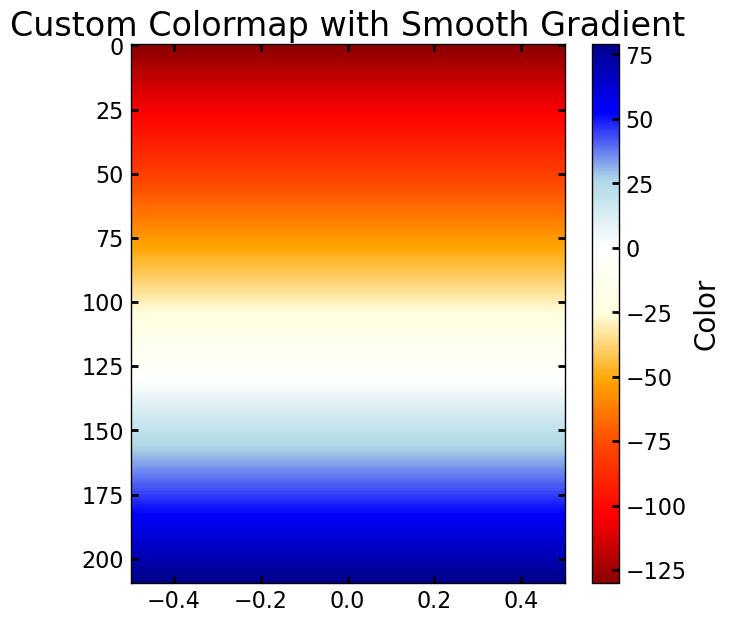

In [63]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors in the desired order
colors = ['darkred', 'red', 'orangered','orange', 'lightyellow', 'white','lightblue', 'blue', 'darkblue']

# Create a list of positions for the colors
positions = [i / (len(colors) - 1) for i in range(len(colors))]

# Create a list of colors repeating the specified colors
colors_list = list(zip(positions, colors))

# Create the colormap
mycmap = LinearSegmentedColormap.from_list('custom_colormap', colors_list)

# Plot a colorbar to visualize the colormap
plt.imshow([[i] for i in range(-130,80)], cmap=mycmap, aspect='auto')
plt.colorbar(label='Color')
plt.title('Custom Colormap with Smooth Gradient')
plt.show()


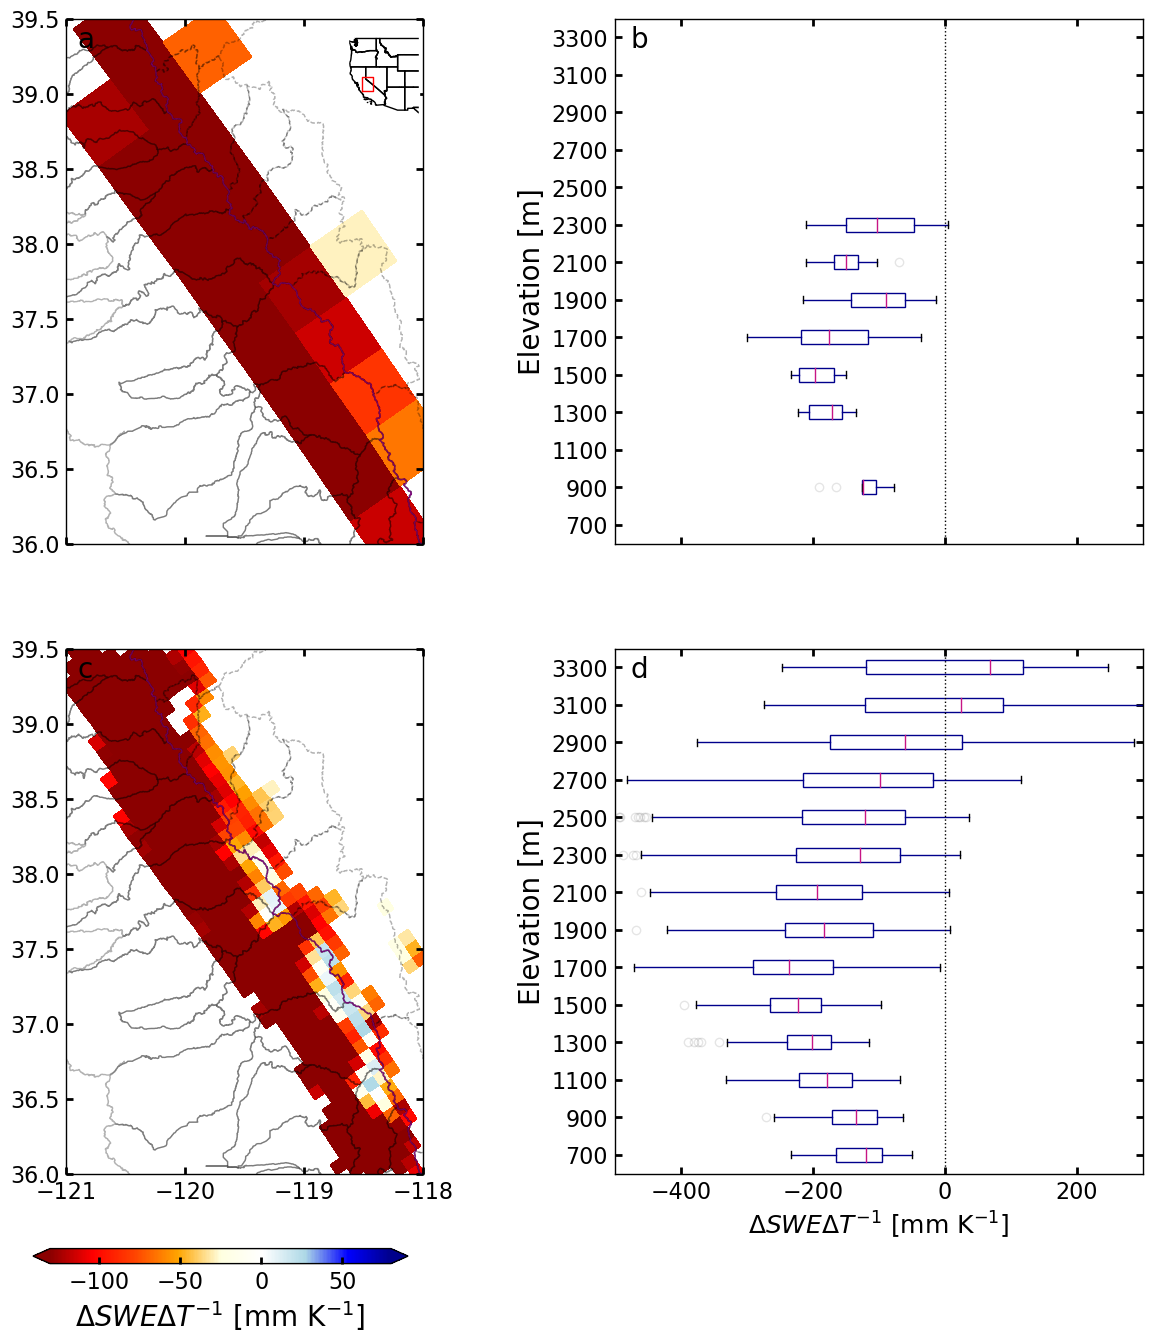

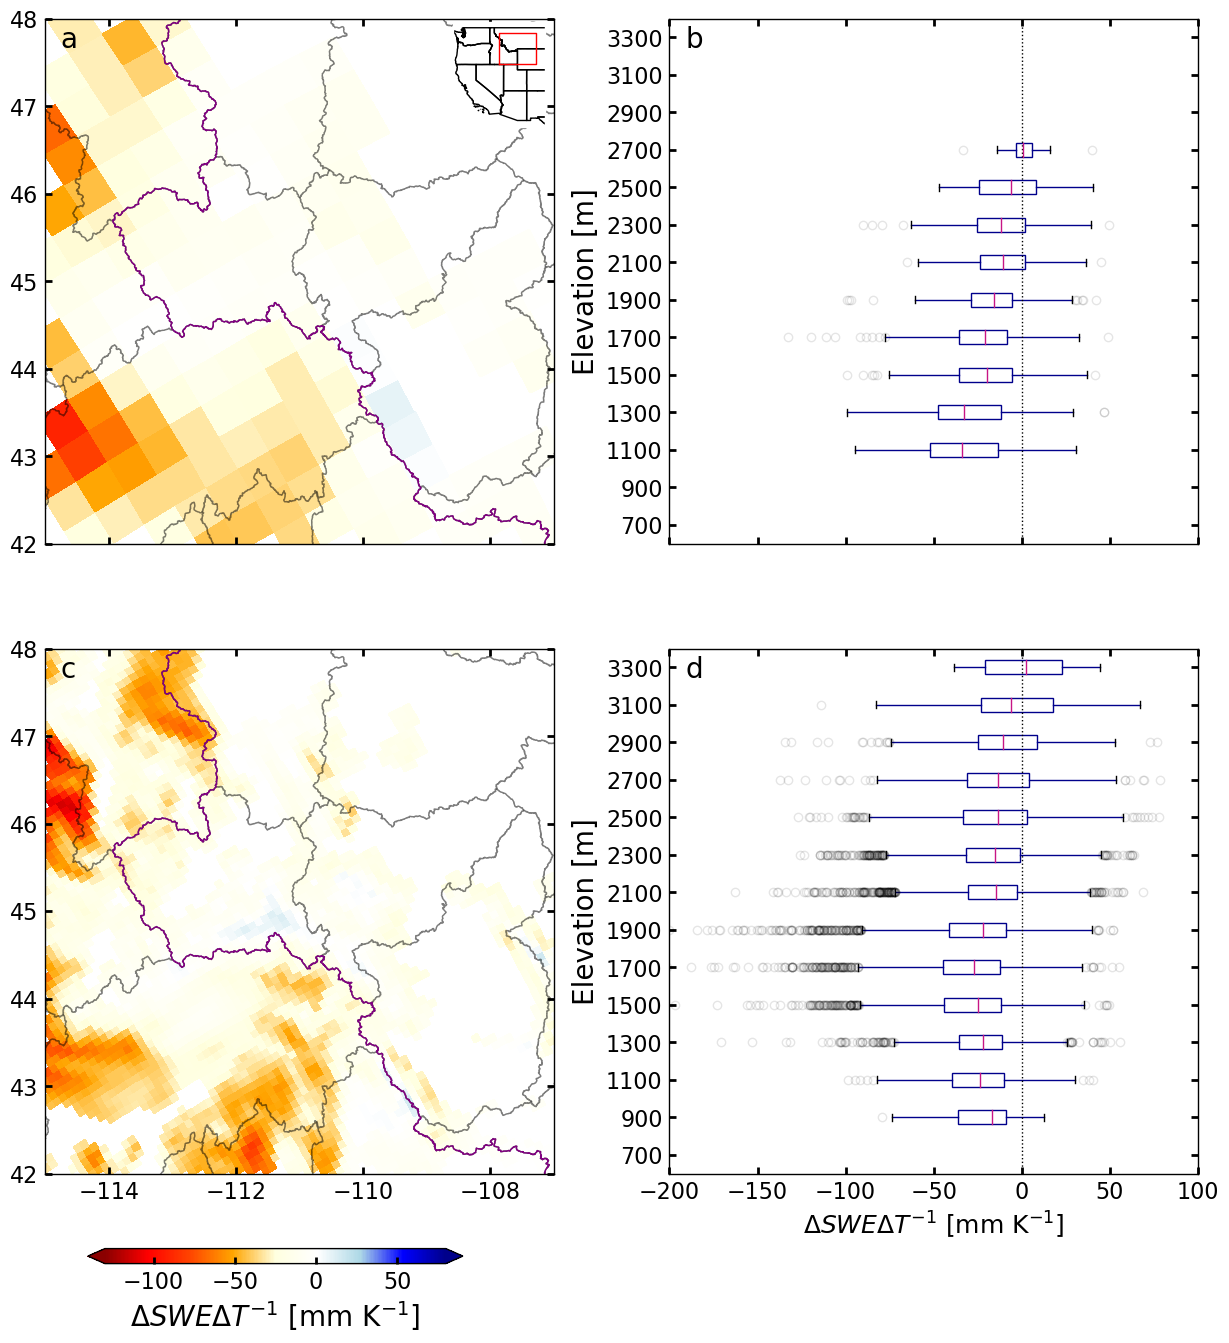

In [64]:
## turn that into two figures, one per state:

calatmin = 36
calatmax = 39.5
calonmin = -121
calonmax = -118
wylatmin = 42# 38
wylatmax = 48 # 48
wylonmin = -115 # -115
wylonmax =  -107 # -104
lims = {'CA': [calatmin, calatmax, calonmin, calonmax],
        'WY': [wylatmin, wylatmax, wylonmin, wylonmax]} 
cmap = mycmap 

vmin = -130
vmax = 80


for j,state in enumerate(['CA' , 'WY']):
    fig,ax = plt.subplots(2,2, figsize = (15,15), sharex = 'col')
    axs = ax.flatten()
    for i in range(2):
        domain = f'd0{i+1}'
        coords = xr.open_dataset(f'{metapath}/wrfinput_{domain}').rename({'south_north':'lat', 'west_east':'lon'})
        snowmax = xr.open_dataarray(f'/glade/campaign/uwyo/wyom0112/berkeley/allsnowmax_BC_{domain}.nc').rename({'lat2d':'lat', 'lon2d':'lon'})
        try:
            snowmask = snowmax.sel(time = slice(snowmax.time[0], snowmax.time[20])).mean(dim='time') > 40
        except:
            snowmask = snowmax.sel(year = slice(snowmax.year[0], snowmax.year[20])).mean(dim='year') > 40
    
            
        snowmask = snowmask.mean(dim='gcm') > 0.4
    
        lat = coords.XLAT[0]
        lon = coords.XLONG[0]
        elev = coords.HGT[0]
    
        mapdata = xr.open_dataset(f'/glade/work/mcowherd/diff_eoc_BC_{domain}.nc').rename({'lat2d':'lat', 'lon2d':'lon'})
        mapdata = mapdata.where(snowmask)

        mylatmin, mylatmax, mylonmin, mylonmax = lims[state]
        # left, right, bottom, top = boundaries2[domain][state]
        #mylat = lat[bottom:top, left:right]
        #mylon = lon[bottom:top, left:right]
        #myelev = elev[bottom:top, left:right]
        latmask = (lat >= mylatmin) & (lat <= mylatmax)
        lonmask = (lon >= mylonmin) & (lon <= mylonmax)
        mydata = mapdata.d_tas# [:,bottom:top, left:right]
        mydata = mydata.where(latmask).where(lonmask)
        myelev = elev.where(latmask).where(lonmask)
        cb = ax[i,0].pcolormesh(lon,lat,mydata.mean(dim='gcm'), cmap = cmap, vmin = vmin, vmax = vmax)
        band_size = 200
        elevation_bands = np.arange(500,3500,band_size)#  np.arange(np.nanmin(myelev), np.nanmax(myelev), band_size)
        groups = []
        for band in elevation_bands:
            mask = (myelev >= band) & (myelev < band + band_size)
            values_in_band = mydata.where(mask)
            vals = values_in_band.values.flatten()
            groups.append(vals[~np.isnan(vals)])

        ax[i,1].boxplot(groups, vert=False, bootstrap = 1000, positions = elevation_bands, widths = 75,
                       flierprops = {'alpha':0.1, 'color': 'darkblue'},
                       patch_artist=True, 
                    boxprops={'color': 'darkblue', 'facecolor': 'white', 'alpha':1.0}, 
                    whiskerprops={'color': 'darkblue'}, 
                    medianprops={'color': 'mediumvioletred'})

            
        latmin, latmax, lonmin, lonmax = lims[state]   
        ax[i,0].set_xlim((lonmin, lonmax))
        ax[i,0].set_ylim((latmin,latmax))
        if state == 'CA':
            in_sn.loc[idx_lee].boundary.plot(ax=ax[i,0], color = 'k',linestyle = '--', alpha = 0.3)
            in_sn.loc[idx_wind].boundary.plot(ax=ax[i,0], color = 'k', alpha = 0.3)
            gdf_overlap.plot(ax=ax[i,0], color =  'purple')# '#332288' )#'purple')
            ax[i,1].set_xlim(-500,300)
        else:       
            huc4_10.boundary.plot(ax = ax[i,0], color = 'k',linestyle = '-', alpha = 0.3)
            huc4_14.boundary.plot(ax = ax[i,0], color = 'k',linestyle = '-', alpha = 0.3)
            huc4_17.boundary.plot(ax = ax[i,0], color = 'k',linestyle = '-', alpha = 0.3)
            huc4_16.boundary.plot(ax = ax[i,0], color = 'k',linestyle = '-', alpha = 0.3)
            huc2_10.boundary.plot(ax = ax[i,0], color = 'purple', alpha = 1)
            ax[i,1].set_xlim(-200,100)
        ax[i,1].plot([0,0],[500,3600], 'k:')
        ax[i,1].set_ylim((600,3400))
            
    ax[0,1].set_ylabel('Elevation [m]')
    ax[1,1].set_ylabel('Elevation [m]')
    ax[1,1].set_xlabel(r'$\Delta SWE \Delta T^{-1}}}$ [mm K$^{-1}$]', size = 18)
    
    cax = fig.add_axes([0.16, 0.05, 0.25, 0.01])  # left, bottom, width, height
    cbar = plt.colorbar(cb, cax=cax, orientation='horizontal', extend = 'both', label = r'$\Delta SWE \Delta T^{-1}}}$ [mm K$^{-1}$]')

    ## add inset axes
    kwargs = {'facecolor':'white',
         'xticklabels': [],
         'yticklabels': []}
    inset_ax = inset_axes(ax[0,0], width="20%",  height="20%", loc=1, borderpad = 0.2, axes_kwargs=kwargs)
    inset_ax.tick_params(bottom=False, left = False, right = False, top = False)
    states.boundary.plot(ax=inset_ax)
    
    if state == 'CA':
        box_bounds = [[calonmin, calonmax, calonmax, calonmin, calonmin],
                  [calatmin, calatmin, calatmax, calatmax, calatmin]]
    if state == 'WY': 
         box_bounds = [[wylonmin, wylonmax, wylonmax, wylonmin, wylonmin],
                  [wylatmin, wylatmin, wylatmax, wylatmax, wylatmin]]
    inset_ax.plot(box_bounds[0], box_bounds[1], color='red')    
    inset_ax.set_xlim((-125,-105))
    inset_ax.set_ylim((30,50))
    inset_ax.spines['bottom'].set_color('w')
    inset_ax.spines['top'].set_color('w')
    inset_ax.spines['left'].set_color('w')
    inset_ax.spines['right'].set_color('w')

        
    for i,ax in enumerate(axs.flatten()): 
        ax.text(0.03, 0.945, chr(i + 97), transform = ax.transAxes)
    
    ##
    plt.savefig(f'../figures/fig_dsdt_{state}.jpg',dpi=400)
    plt.show()
       

3
6
6


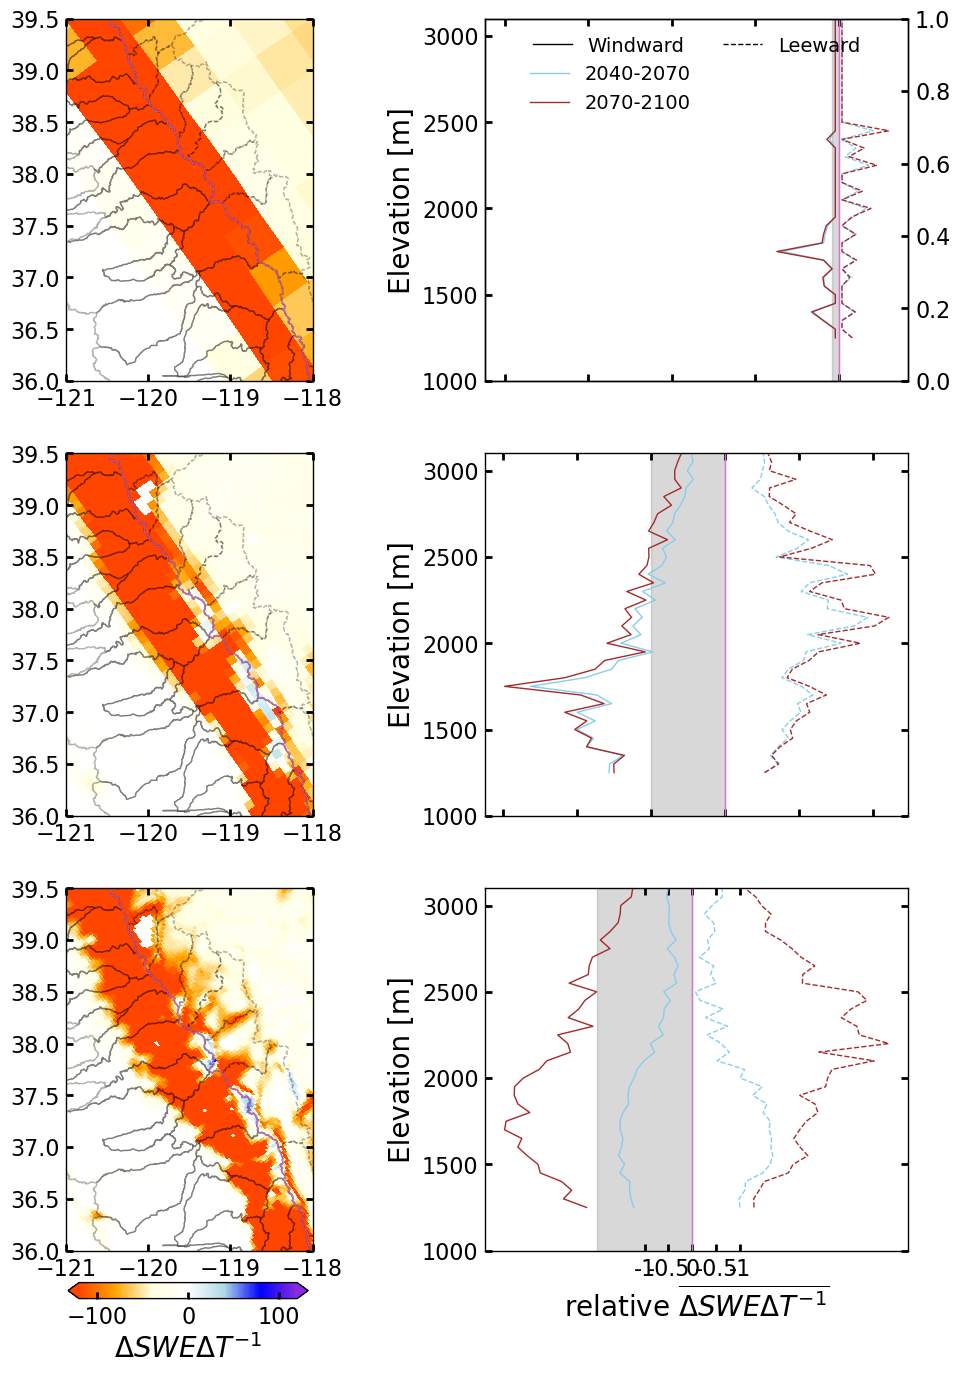

In [10]:
import cmcrameri.cm as ccm
maps, profiles_e, profiles_m, elev_bins = prep_figdata('CA')

cmap = ccm.broc_r
cmap = mycmap 
fig,ax = plt.subplots(3,2, figsize = (12,16))
axs = ax.flatten()
e = elev_bins[1:]
k=0
axs[1].plot([-100,-10],[-100,-10],'k-',label = 'Windward')
axs[1].plot([-100,-10],[-100,-10],'k--',label = 'Leeward')

axs[1].plot([-100,-10],[-100,-10],color = 'skyblue',label = '2040-2070')
axs[1].plot([-100,-10],[-100,-10],color = 'brown',label = '2070-2100')

for i in range(3):
    lon,lat,mapdata = maps[i]
    cb = axs[k].pcolormesh(lon,lat,mapdata, cmap = cmap, vmin = -120, vmax = 120)
    
    in_sn.loc[idx_lee].boundary.plot(ax=axs[k], color = 'k',linestyle = '--', alpha = 0.3)
    in_sn.loc[idx_wind].boundary.plot(ax=axs[k], color = 'k', alpha = 0.3)
    gdf_overlap.plot(ax=axs[k], color =  'orchid')# '#332288' )#'purple')

    ## midc ##
    leeplot = profiles_m[k]
    windplot = profiles_m[k+1]
    # leeplot = (leeplot-np.nanmin(leeplot))/ (np.nanmax(leeplot) - np.nanmin(leeplot))
    # windplot = (windplot-np.nanmin(windplot))/ (np.nanmax(windplot) - np.nanmin(windplot))
    if i == 0:
        #mask = (1-leeplot) > 0
        e2 = e# [mask]
        leeplot = leeplot# [mask]
        windplot = windplot# [mask]
    else: e2 = e
    axs[k+1].plot(1-leeplot,e2, linestyle = '--', color = 'skyblue')
    axs[k+1].plot(windplot-1,e2, linestyle = '-', color = 'skyblue')
    
    ##eoc##
    leeplot = profiles_e[k]
    windplot = profiles_e[k+1]
    #leeplot = leeplot / np.nanmean(leeplot) 
    # leeplot = (leeplot-np.nanmin(leeplot))/ (np.nanmax(leeplot) - np.nanmin(leeplot))
    # windplot = windplot / np.nanmean(windplot) 
    # windplot = (windplot-np.nanmin(windplot))/ (np.nanmax(windplot) - np.nanmin(windplot))
    if i == 0:
        #mask = (1-leeplot) > 0
        leeplot = leeplot# [mask]
        windplot = windplot# [mask]
    axs[k+1].plot(1-leeplot,e2, linestyle = '--', color = 'brown')
    axs[k+1].plot(windplot-1,e2, linestyle = '-', color = 'brown')

    ## formatting
    axs[k].set_xlim((-121, -118))
    axs[k].set_ylim((36,39.5))
    axs[k+1].set_ylabel('Elevation [m]', fontsize = 20)
    axs[k+1].set_xticklabels([])
    axs[k+1].vlines(x=0, ymin=1000, ymax=3500, color='orchid', linewidth=1)
    axs[k+1].fill_betweenx([900,3500], -2, 0, alpha=0.3, color='gray')
    axs[k+1].set_ylim((1000,3100))
    # axs[k+1].set_xlim((-1.1,1.1))
    
    k+=2
h, l = axs[1].get_legend_handles_labels()
h.insert(2, h[0])
l.insert(2, '')
axs[1].legend(h[0:2], l[0:2], loc = 'upper center', ncol = 2)
axs[1].twinx().legend(h[3:], l[3:], loc = 'upper left', ncol = 1, bbox_to_anchor = (0.065,0.92))
axs[k-1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[k-1].set_xticklabels([-1, -0.5, 0, -0.5, -1])
axs[k-1].set_xlabel(r'relative $ \overline{\Delta SWE \Delta T^{-1}}}$', fontsize = 20)

cax = fig.add_axes([0.20, 0.08, 0.20, 0.01])  # left, bottom, width, height
cbar = plt.colorbar(cb, cax=cax, orientation='horizontal', extend = 'both', label = r'$\Delta SWE \Delta T^{-1}}}$')

plt.show()
    

3
3
3


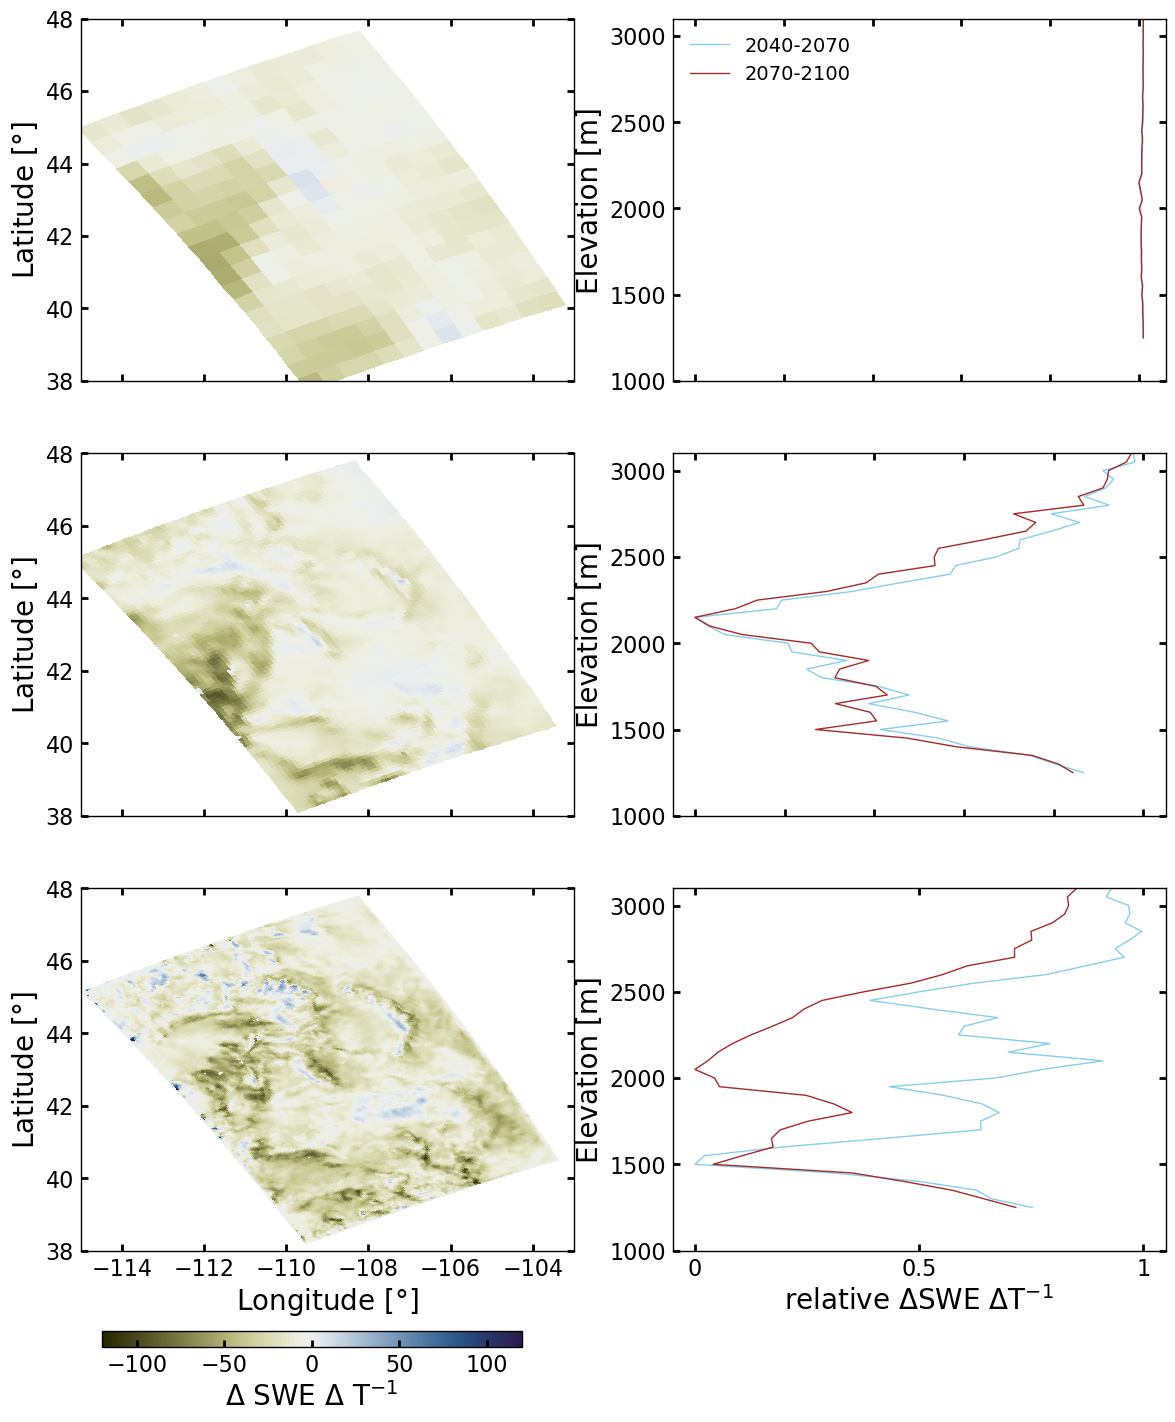

In [11]:
## WYOMING ##
import cmcrameri.cm as ccm
maps, profiles_e, profiles_m, elev_bins = prep_figdata('WY')

cmap = ccm.broc_r
fig,ax = plt.subplots(3,2, figsize = (14,16))
axs = ax.flatten()
e = elev_bins[1:]
k=0
axs[1].plot([-100,-10],[-100,-10],color = 'skyblue',label = '2040-2070')
axs[1].plot([-100,-10],[-100,-10],color = 'brown',label = '2070-2100')

for i in range(3):
    lon,lat,mapdata = maps[i]
    cb = axs[k].pcolormesh(lon,lat,mapdata, cmap = cmap, vmin = -120, vmax = 120)
    
    ## midc ##
    leeplot = profiles_m[i]
    leeplot = ((leeplot)-np.nanmin(leeplot))/ (np.nanmax(leeplot) - np.nanmin(leeplot))
    axs[k+1].plot(leeplot,e, linestyle = '-', color = 'skyblue')
    
    ##eoc##
    leeplot = profiles_e[i]
    leeplot = ((leeplot)-np.nanmin(leeplot))/ (np.nanmax(leeplot) - np.nanmin(leeplot))
    axs[k+1].plot(leeplot,e, linestyle = '-', color = 'brown')

    ## formatting
    axs[k].set_xlim((-115, -103))
    axs[k].set_ylim((38,48))
    axs[k].set_ylabel(r'Latitude [$\degree$]', fontsize = 20)
    axs[k+1].set_ylabel('Elevation [m]', fontsize = 20)
    ##
    #huc4_14.boundary.plot(ax = axs[k], color = 'r',linestyle = '-', alpha = 0.3)
    #huc4_10.boundary.plot(ax = axs[k], color = 'k',linestyle = '-', alpha = 0.3)
    ##
    axs[k+1].set_xticklabels([])
    axs[k+1].set_ylim((1000,3100))
    # axs[k+1].set_xlim((-0.2,1.1))
    if i < 2:
        axs[k].set_xticklabels([])
    k+=2

h,l = axs[1].get_legend_handles_labels()  
axs[1].legend(h, l, loc = 'upper left', ncol = 1)
axs[k-2].set_xlabel(r'Longitude [$\degree$]', fontsize = 20)
axs[k-1].set_xticks([0, 0.5, 1])
axs[k-1].set_xticklabels([0, 0.5, 1])
axs[k-1].set_xlabel(r'relative $\Delta$SWE $\Delta$T$^{-1}$', fontsize = 20)

cax = fig.add_axes([0.14, 0.05, 0.3, 0.01])  # left, bottom, width, height
cbar = plt.colorbar(cb, cax=cax, orientation='horizontal')
cbar.set_label(r'$\Delta$ SWE $\Delta$ T$^{-1}$', fontsize = 20)

plt.show()
    

3
6
6
3
3
3


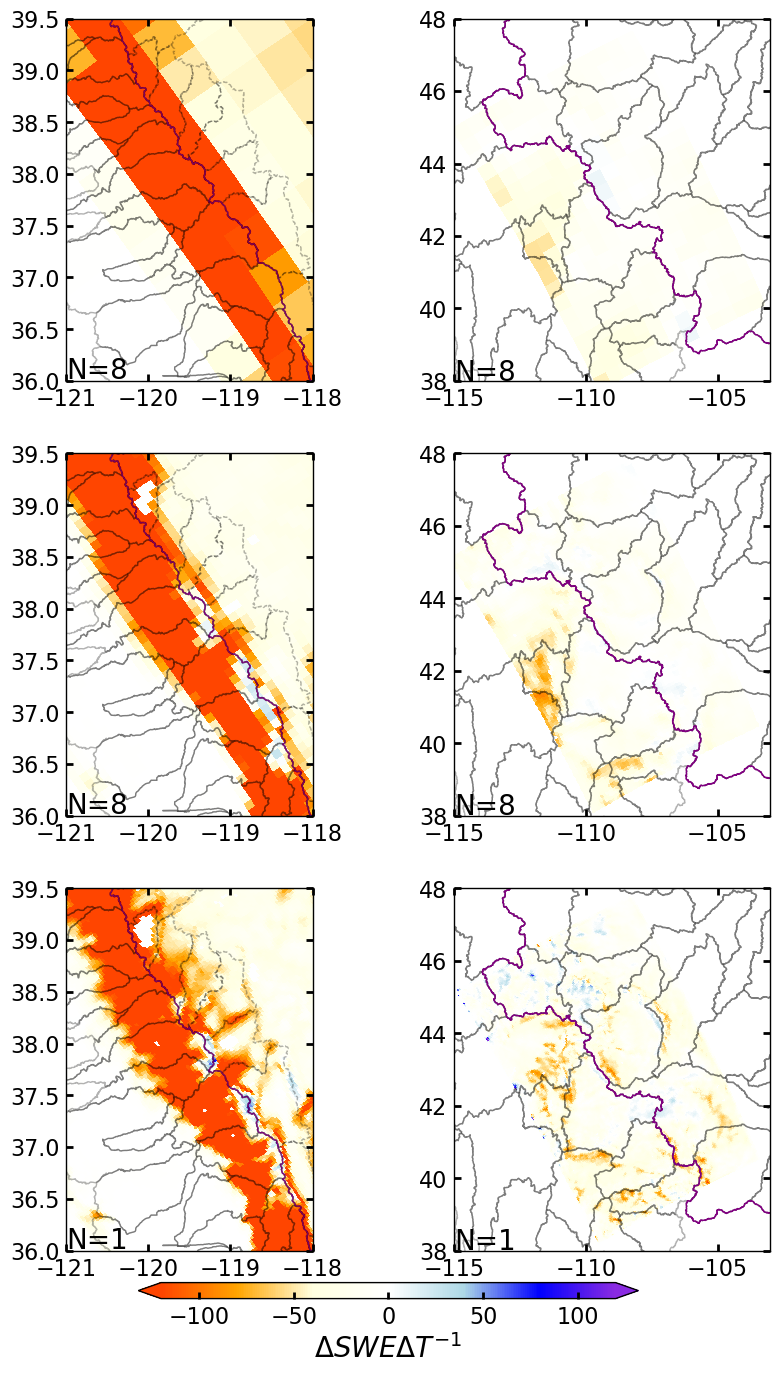

CPU times: user 42.1 s, sys: 120 ms, total: 42.2 s
Wall time: 42.3 s


In [12]:
%%time
mapsC, profiles_eC, profiles_mC, elev_binsC = prep_figdata('CA')
mapsW, profiles_eW, profiles_mC, elev_binsW = prep_figdata('WY')

huc2_10 = gpd.read_file('../data/huc10/WBDHU2.shp')
cmap = mycmap 
fig,ax = plt.subplots(3,2, figsize = (10,16))
axs = ax.flatten()
for i in range(3):
    lon,lat,mapdata = mapsC[i]
    axC = ax[i,0]
    cb = ax[i,0].pcolormesh(lon,lat,mapdata, cmap = cmap, vmin = -120, vmax = 120)
    ax[i,0].set_xlim((-121, -118))
    ax[i,0].set_ylim((36,39.5))
    in_sn.loc[idx_lee].boundary.plot(ax=axC, color = 'k',linestyle = '--', alpha = 0.3)
    in_sn.loc[idx_wind].boundary.plot(ax=axC, color = 'k', alpha = 0.3)
    gdf_overlap.plot(ax=axC, color =  'purple')# '#332288' )#'purple')

    axW = ax[i,1]
    lon, lat, mapdata = mapsW[i]
    cb = ax[i,1].pcolormesh(lon,lat,mapdata, cmap = cmap, vmin = -120, vmax = 120)
    ax[i,1].set_xlim((-115, -103))
    ax[i,1].set_ylim((38,48))
    huc4_10.boundary.plot(ax = axW, color = 'k',linestyle = '-', alpha = 0.3)
    huc4_14.boundary.plot(ax = axW, color = 'k',linestyle = '-', alpha = 0.3)
    huc4_17.boundary.plot(ax = axW, color = 'k',linestyle = '-', alpha = 0.3)
    huc4_16.boundary.plot(ax = axW, color = 'k',linestyle = '-', alpha = 0.3)
    huc2_10.boundary.plot(ax = axW, color = 'purple', alpha = 1)
    
    
cax = fig.add_axes([0.25, 0.08, 0.5, 0.01])  # left, bottom, width, height
cbar = plt.colorbar(cb, cax=cax, orientation='horizontal', extend = 'both', label = r'$\Delta SWE \Delta T^{-1}}}$')
ax[0,0].text(-121,36.02,'N=8')
ax[1,0].text(-121,36.02,'N=8')
ax[0,1].text(-115,38.02,'N=8')
ax[1,1].text(-115,38.02,'N=8')
ax[2,0].text(-121,36.02,'N=1')
ax[2,1].text(-115,38.02,'N=1')

plt.savefig('../figures/fig_dswedt_ca.jpg', dpi = 400)
plt.show()
   

In [ ]:
boundaries2 = boundaries.copy()

In [14]:
snowmax2 = xr.open_dataarray('/glade/campaign/uwyo/wyom0112/berkeley/allsnowmax_BC_d02.nc')
snowmask2 = snowmax2 > 40
snowmax1 = xr.open_dataarray('/glade/campaign/uwyo/wyom0112/berkeley/allsnowmax_BC_d01.nc')
snowmask1 = snowmax1 > 40

In [15]:
boundaries2['d01']['WY'] = [62,86,40,75]
boundaries2['d02']['WY'] = [155,280,100,250]

In [16]:
snowmask = snowmax2.sel(time = slice(snowmax2.time[0], snowmax2.time[20])).mean(dim='time') > 40
snowmask = snowmask.mean(dim='gcm') > 0.4


NameError: name 'axC' is not defined

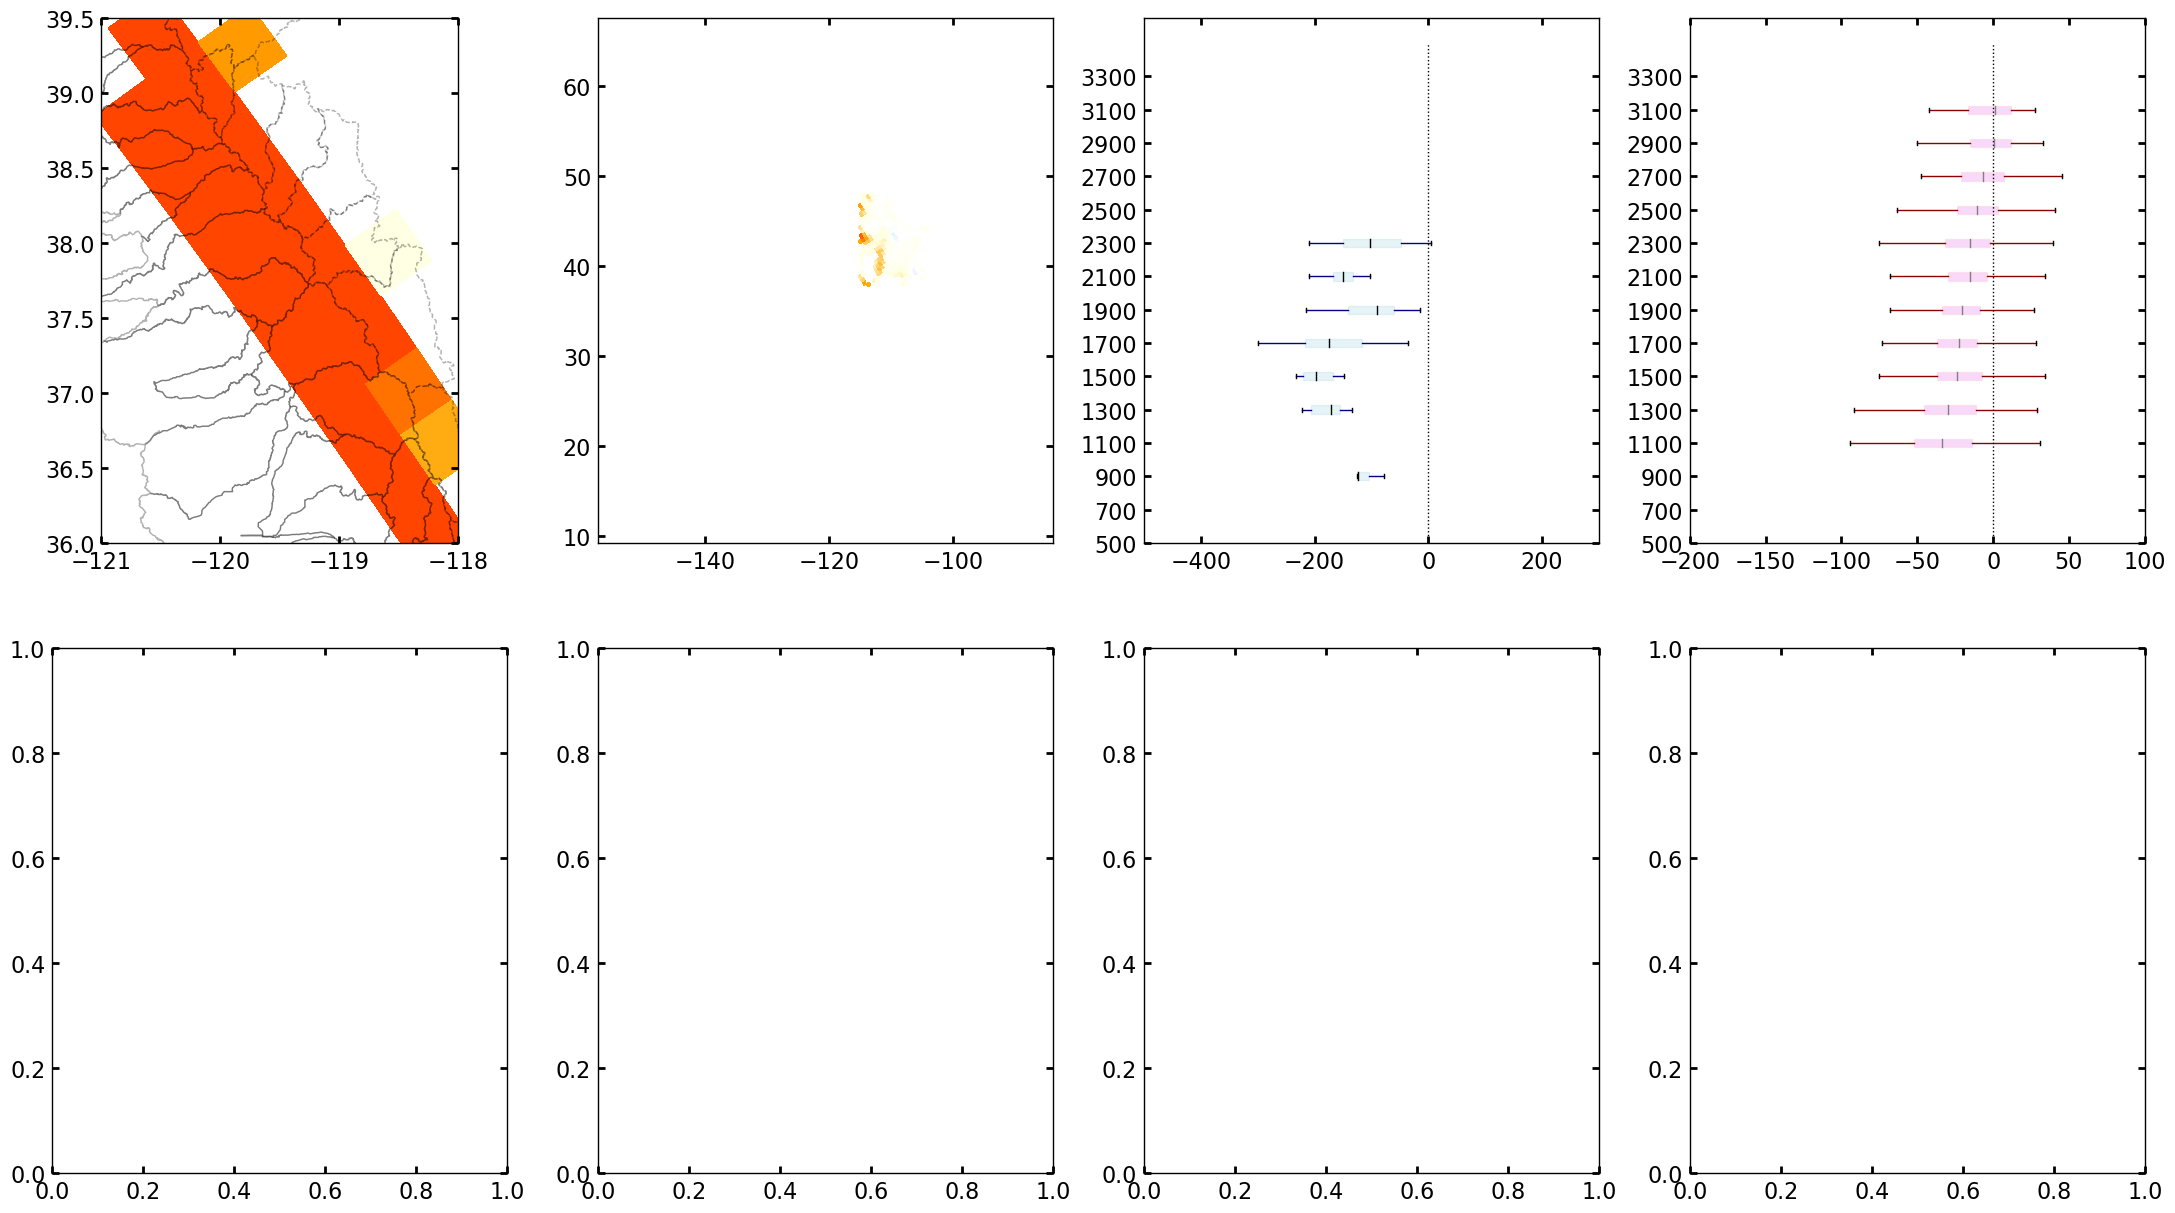

In [26]:
calatmin = 36
calatmax = 39.5
calonmin = -121
calonmax = -118
wylatmin = 38
wylatmax = 48
wylonmin = -115
wylonmax =  -104
lims = {'CA': [calatmin, calatmax, calonmin, calonmax],
        'WY': [wylatmin, wylatmax, wylonmin, wylonmax]} 
cmap = mycmap 
fig,ax = plt.subplots(2,4, figsize = (27,15))
axs = ax.flatten()
for i in range(2):
    domain = f'd0{i+1}'
    coords = xr.open_dataset(f'{metapath}/wrfinput_{domain}').rename({'south_north':'lat', 'west_east':'lon'})
    snowmax = xr.open_dataarray(f'/glade/campaign/uwyo/wyom0112/berkeley/allsnowmax_BC_{domain}.nc').rename({'lat2d':'lat', 'lon2d':'lon'})
    try:
        snowmask = snowmax.sel(time = slice(snowmax.time[0], snowmax.time[20])).mean(dim='time') > 40
    except:
        snowmask = snowmax.sel(year = slice(snowmax.year[0], snowmax.year[20])).mean(dim='year') > 40

        
    snowmask = snowmask.mean(dim='gcm') > 0.4

    lat = coords.XLAT[0]
    lon = coords.XLONG[0]
    elev = coords.HGT[0]

    mapdata = xr.open_dataset(f'/glade/work/mcowherd/diff_eoc_BC_{domain}.nc').rename({'lat2d':'lat', 'lon2d':'lon'})
    mapdata = mapdata.where(snowmask)

    for j,state in enumerate(['CA' , 'WY']):
        mylatmin, mylatmax, mylonmin, mylonmax = lims[state]
        # left, right, bottom, top = boundaries2[domain][state]
        #mylat = lat[bottom:top, left:right]
        #mylon = lon[bottom:top, left:right]
        #myelev = elev[bottom:top, left:right]
        latmask = (lat >= mylatmin) & (lat <= mylatmax)
        lonmask = (lon >= mylonmin) & (lon <= mylonmax)
        mydata = mapdata.d_tas# [:,bottom:top, left:right]
        mydata = mydata.where(latmask).where(lonmask)
        myelev = elev.where(latmask).where(lonmask)
        cb = ax[i,j].pcolormesh(lon,lat,mydata.mean(dim='gcm'), cmap = cmap, vmin = -100, vmax = 100)
        band_size = 200
        elevation_bands = np.arange(500,3500,band_size)#  np.arange(np.nanmin(myelev), np.nanmax(myelev), band_size)
        groups = []
        for band in elevation_bands:
            mask = (myelev >= band) & (myelev < band + band_size)
            values_in_band = mydata.where(mask)
            vals = values_in_band.values.flatten()
            groups.append(vals[~np.isnan(vals)])
        if state == 'CA':
            ax[i,2].boxplot(groups, vert=False, bootstrap = 1000, positions = elevation_bands, widths = 50,
                           flierprops = {'alpha':0.0},
                           patch_artist=True, 
                        boxprops={'color': 'lightblue', 'facecolor': 'lightblue', 'alpha':0.3}, 
                        whiskerprops={'color': 'darkblue'}, 
                        medianprops={'color': 'black'})
            ax[i,2].plot([0,0],[500,3500], 'k:')
            ax[i,2].set_xlim(-500,300)
        else:
            ax[i,3].boxplot(groups, vert=False, bootstrap = 1000, positions = elevation_bands, widths = 50,
               flierprops = {'alpha':0.0},
               patch_artist=True, 
            boxprops={'color': 'pink', 'facecolor': 'violet', 'alpha':0.3}, 
            whiskerprops={'color': 'darkred'}, 
            medianprops={'color': 'gray'})
            ax[i,3].plot([0,0],[500,3500], 'k:')
            ax[i,3].set_xlim(-200,100)
            
            
    ax[i,0].set_xlim((calonmin, calonmax))
    ax[i,0].set_ylim((calatmin,calatmax))
    in_sn.loc[idx_lee].boundary.plot(ax=ax[i,0], color = 'k',linestyle = '--', alpha = 0.3)
    in_sn.loc[idx_wind].boundary.plot(ax=ax[i,0], color = 'k', alpha = 0.3)
    gdf_overlap.plot(ax=axC, color =  'purple')# '#332288' )#'purple')
    ax[i,1].set_xlim((wylonmin, wylonmax))
    ax[i,1].set_ylim((wylatmin, wylatmax))
    huc4_10.boundary.plot(ax = ax[i,1], color = 'k',linestyle = '-', alpha = 0.3)
    huc4_14.boundary.plot(ax = ax[i,1], color = 'k',linestyle = '-', alpha = 0.3)
    huc4_17.boundary.plot(ax = ax[i,1], color = 'k',linestyle = '-', alpha = 0.3)
    huc4_16.boundary.plot(ax = ax[i,1], color = 'k',linestyle = '-', alpha = 0.3)
    huc2_10.boundary.plot(ax = ax[i,1], color = 'purple', alpha = 1)
    
ax[0,2].set_ylabel('Elevation [m]')
ax[1,2].set_ylabel('Elevation [m]')
ax[0,3].set_yticklabels([])
ax[1,3].set_yticklabels([])
ax[0,2].set_xticklabels([])
ax[0,3].set_xticklabels([])
ax[1,2].set_xlabel(r'$\Delta SWE \Delta T^{-1}}}$ [mm K$^{-1}$]', size = 14)
ax[1,3].set_xlabel(r'$\Delta SWE \Delta T^{-1}}}$ [mm K$^{-1}$]', size = 14)

cax = fig.add_axes([0.15, 0.04, 0.25, 0.01])  # left, bottom, width, height
cbar = plt.colorbar(cb, cax=cax, orientation='horizontal', extend = 'both', label = r'$\Delta SWE \Delta T^{-1}}}$ [mm K$^{-1}$]')
# plt.tight_layout()
plt.show()
   

TypeError: 'norm' must be an instance of matplotlib.colors.Normalize, str or None, not a __main__.CustomNorm

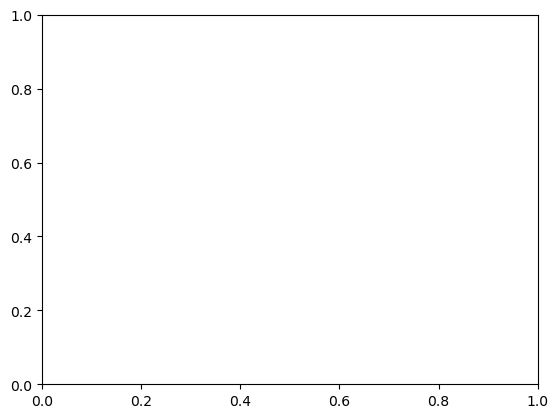

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the colormap
colors = [(0, '#4567b7'), (0.5, '#ffffff'), (1, '#ff6e42')]

# Create the colormap
cmap = LinearSegmentedColormap.from_list('', colors)

# Define the bounds for the colormap
vmin = -150
vmax = 50
vcenter = 0

# Create a custom normalization object
class CustomNorm:
    def __init__(self, vmin, vmax, vcenter):
        self.vmin = vmin
        self.vmax = vmax
        self.vcenter = vcenter

    def __call__(self, value):
        if value < self.vcenter:
            return (value - self.vmin) / (self.vcenter - self.vmin) * 0.5
        else:
            return 0.5 + (value - self.vcenter) / (self.vmax - self.vcenter) * 0.5

norm = CustomNorm(vmin, vmax, vcenter)

# Create a test plot
x = np.linspace(-150, 50, 100)
y = np.linspace(-150, 50, 100)
X, Y = np.meshgrid(x, y)
Z = X

plt.pcolor(X, Y, Z, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()


NameError: name 'inset_axes' is not defined

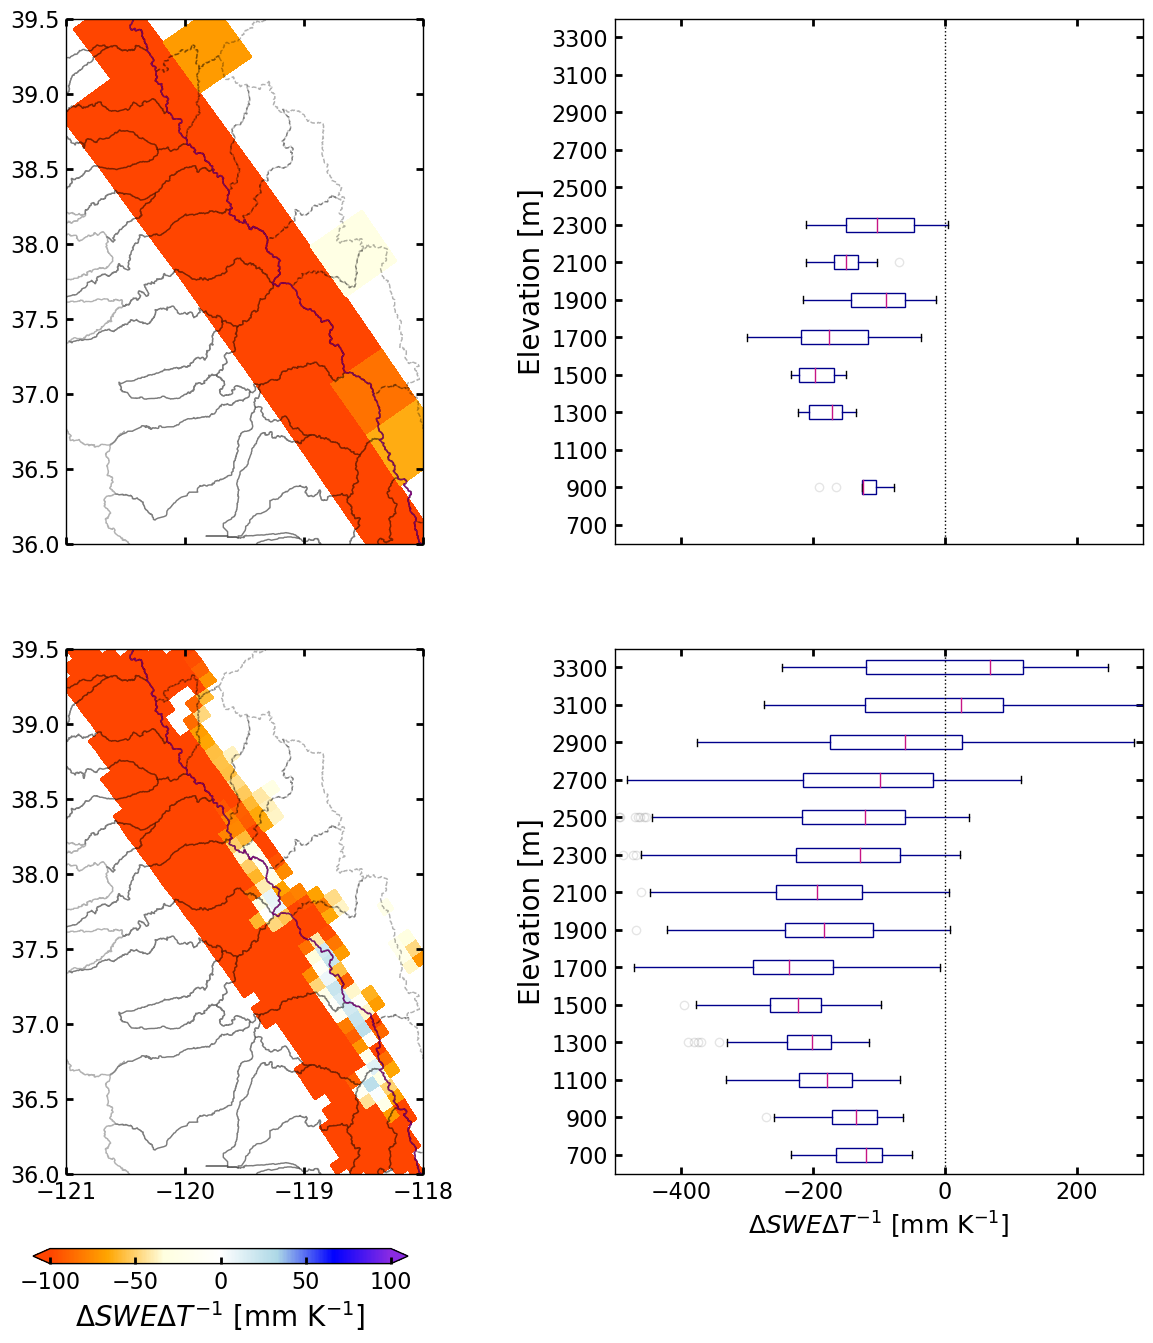

In [28]:
## turn that into two figures, one per state:

calatmin = 36
calatmax = 39.5
calonmin = -121
calonmax = -118
wylatmin = 42# 38
wylatmax = 48 # 48
wylonmin = -115 # -115
wylonmax =  -107 # -104
lims = {'CA': [calatmin, calatmax, calonmin, calonmax],
        'WY': [wylatmin, wylatmax, wylonmin, wylonmax]} 
cmap = mycmap 


for j,state in enumerate(['CA' , 'WY']):
    fig,ax = plt.subplots(2,2, figsize = (15,15), sharex = 'col')
    axs = ax.flatten()
    for i in range(2):
        domain = f'd0{i+1}'
        coords = xr.open_dataset(f'{metapath}/wrfinput_{domain}').rename({'south_north':'lat', 'west_east':'lon'})
        snowmax = xr.open_dataarray(f'/glade/campaign/uwyo/wyom0112/berkeley/allsnowmax_BC_{domain}.nc').rename({'lat2d':'lat', 'lon2d':'lon'})
        try:
            snowmask = snowmax.sel(time = slice(snowmax.time[0], snowmax.time[20])).mean(dim='time') > 40
        except:
            snowmask = snowmax.sel(year = slice(snowmax.year[0], snowmax.year[20])).mean(dim='year') > 40
    
            
        snowmask = snowmask.mean(dim='gcm') > 0.4
    
        lat = coords.XLAT[0]
        lon = coords.XLONG[0]
        elev = coords.HGT[0]
    
        mapdata = xr.open_dataset(f'/glade/work/mcowherd/diff_eoc_BC_{domain}.nc').rename({'lat2d':'lat', 'lon2d':'lon'})
        mapdata = mapdata.where(snowmask)

        mylatmin, mylatmax, mylonmin, mylonmax = lims[state]
        # left, right, bottom, top = boundaries2[domain][state]
        #mylat = lat[bottom:top, left:right]
        #mylon = lon[bottom:top, left:right]
        #myelev = elev[bottom:top, left:right]
        latmask = (lat >= mylatmin) & (lat <= mylatmax)
        lonmask = (lon >= mylonmin) & (lon <= mylonmax)
        mydata = mapdata.d_tas# [:,bottom:top, left:right]
        mydata = mydata.where(latmask).where(lonmask)
        myelev = elev.where(latmask).where(lonmask)
        cb = ax[i,0].pcolormesh(lon,lat,mydata.mean(dim='gcm'), cmap = cmap, vmin = -100, vmax = 100)
        band_size = 200
        elevation_bands = np.arange(500,3500,band_size)#  np.arange(np.nanmin(myelev), np.nanmax(myelev), band_size)
        groups = []
        for band in elevation_bands:
            mask = (myelev >= band) & (myelev < band + band_size)
            values_in_band = mydata.where(mask)
            vals = values_in_band.values.flatten()
            groups.append(vals[~np.isnan(vals)])

        ax[i,1].boxplot(groups, vert=False, bootstrap = 1000, positions = elevation_bands, widths = 75,
                       flierprops = {'alpha':0.1, 'color': 'darkblue'},
                       patch_artist=True, 
                    boxprops={'color': 'darkblue', 'facecolor': 'white', 'alpha':1.0}, 
                    whiskerprops={'color': 'darkblue'}, 
                    medianprops={'color': 'mediumvioletred'})

            
        latmin, latmax, lonmin, lonmax = lims[state]   
        ax[i,0].set_xlim((lonmin, lonmax))
        ax[i,0].set_ylim((latmin,latmax))
        if state == 'CA':
            in_sn.loc[idx_lee].boundary.plot(ax=ax[i,0], color = 'k',linestyle = '--', alpha = 0.3)
            in_sn.loc[idx_wind].boundary.plot(ax=ax[i,0], color = 'k', alpha = 0.3)
            gdf_overlap.plot(ax=ax[i,0], color =  'purple')# '#332288' )#'purple')
            ax[i,1].set_xlim(-500,300)
        else:       
            huc4_10.boundary.plot(ax = ax[i,0], color = 'k',linestyle = '-', alpha = 0.3)
            huc4_14.boundary.plot(ax = ax[i,0], color = 'k',linestyle = '-', alpha = 0.3)
            huc4_17.boundary.plot(ax = ax[i,0], color = 'k',linestyle = '-', alpha = 0.3)
            huc4_16.boundary.plot(ax = ax[i,0], color = 'k',linestyle = '-', alpha = 0.3)
            huc2_10.boundary.plot(ax = ax[i,0], color = 'purple', alpha = 1)
            ax[i,1].set_xlim(-200,100)
        ax[i,1].plot([0,0],[500,3600], 'k:')
        ax[i,1].set_ylim((600,3400))
            
    ax[0,1].set_ylabel('Elevation [m]')
    ax[1,1].set_ylabel('Elevation [m]')
    ax[1,1].set_xlabel(r'$\Delta SWE \Delta T^{-1}}}$ [mm K$^{-1}$]', size = 18)
    
    cax = fig.add_axes([0.16, 0.05, 0.25, 0.01])  # left, bottom, width, height
    cbar = plt.colorbar(cb, cax=cax, orientation='horizontal', extend = 'both', label = r'$\Delta SWE \Delta T^{-1}}}$ [mm K$^{-1}$]')

    ## add inset axes
    kwargs = {'facecolor':'white',
         'xticklabels': [],
         'yticklabels': []}
    inset_ax = inset_axes(ax[0,0], width="20%",  height="20%", loc=1, borderpad = 0.2, axes_kwargs=kwargs)
    inset_ax.tick_params(bottom=False, left = False, right = False, top = False)
    states.boundary.plot(ax=inset_ax)
    
    if state == 'CA':
        box_bounds = [[calonmin, calonmax, calonmax, calonmin, calonmin],
                  [calatmin, calatmin, calatmax, calatmax, calatmin]]
    if state == 'WY': 
         box_bounds = [[wylonmin, wylonmax, wylonmax, wylonmin, wylonmin],
                  [wylatmin, wylatmin, wylatmax, wylatmax, wylatmin]]
    inset_ax.plot(box_bounds[0], box_bounds[1], color='red')    
    inset_ax.set_xlim((-125,-105))
    inset_ax.set_ylim((30,50))
    inset_ax.spines['bottom'].set_color('w')
    inset_ax.spines['top'].set_color('w')
    inset_ax.spines['left'].set_color('w')
    inset_ax.spines['right'].set_color('w')

        
    for i,ax in enumerate(axs.flatten()): 
        ax.text(0.03, 0.945, chr(i + 97), transform = ax.transAxes)
    
    ##
    plt.savefig(f'../figures/fig_dsdt_{state}.jpg',dpi=400)
    plt.show()
       

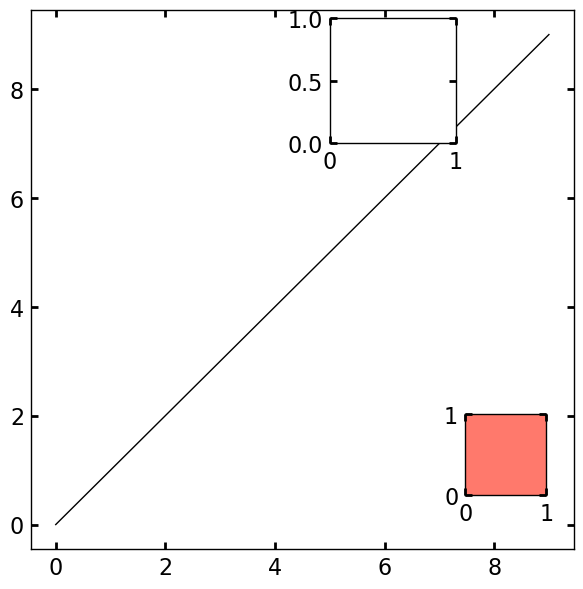

In [71]:

fig, ax = plt.subplots()
ax.plot(range(10))
axin1 = ax.inset_axes([0.8, 0.1, 0.15, 0.15])
axin2 = ax.inset_axes(
        [5, 7, 2.3, 2.3], transform=ax.transData)

axin1.set_facecolor('xkcd:salmon')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


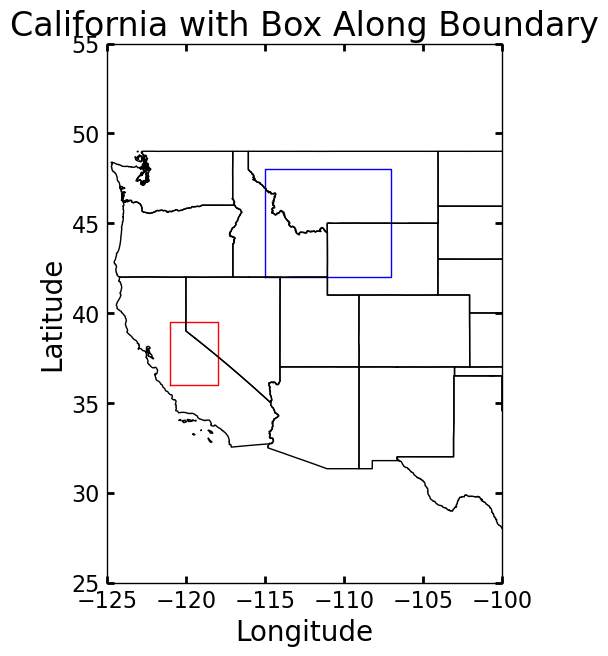

In [57]:


# Define the bounds for California
# Create the main plot
fig, ax = plt.subplots()
box_bounds = [[calonmin, calonmax, calonmax, calonmin, calonmin],
              [calatmin, calatmin, calatmax, calatmax, calatmin]]
ax.plot(box_bounds[0], box_bounds[1], color='red')

box_bounds = [[wylonmin, wylonmax, wylonmax, wylonmin, wylonmin],
              [wylatmin, wylatmin, wylatmax, wylatmax, wylatmin]]
ax.plot(box_bounds[0], box_bounds[1], color='blue')
states.boundary.plot(ax=ax)

# Set plot labels and legend
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('California with Box Along Boundary')
ax.legend()
ax.set_xlim((-125,-100))
ax.set_ylim((25,55))
# Show the plot
plt.show()


(30.0, 50.0)

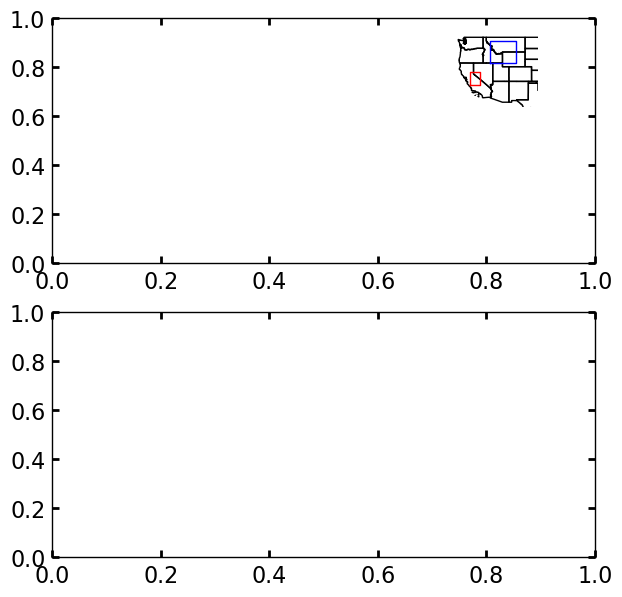

In [58]:
fig, axs = plt.subplots(2)

i = 0
kwargs = {'frameon':False,
         'xticklabels': [],
         'yticklabels': []}
inset_ax = inset_axes(axs[i], width="30%",  height="30%", loc=1, borderpad = 0.8, axes_kwargs=kwargs)
inset_ax.tick_params(bottom=False, left = False, right = False, top = False)
states.boundary.plot(ax=inset_ax)
box_bounds = [[calonmin, calonmax, calonmax, calonmin, calonmin],
              [calatmin, calatmin, calatmax, calatmax, calatmin]]
inset_ax.plot(box_bounds[0], box_bounds[1], color='red')

box_bounds = [[wylonmin, wylonmax, wylonmax, wylonmin, wylonmin],
              [wylatmin, wylatmin, wylatmax, wylatmax, wylatmin]]
inset_ax.plot(box_bounds[0], box_bounds[1], color='blue')
inset_ax.set_xlim((-125,-100))
inset_ax.set_ylim((30,50))

# inset_ax.text(0,0,basins_to_plot[i].name[0])
# geom_arg[0].to_crs(proj).plot(ax=inset_ax, color = 'k', linewidth = 1, alpha = 1)
# inset_ax.set_xlim(geom_arg[1])
# inset_ax.set_ylim(geom_arg[2]) 

<Axes: >

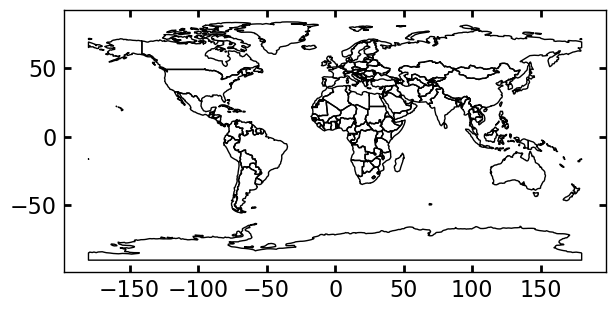

In [32]:
world.boundary.plot()

In [26]:
world

NameError: name 'world' is not defined

In [ ]:
latmask = (mylat >= mylatmin) & (mylat <= mylatmax)
lonmask = (mylon >= mylonmin) & (mylon <= mylonmax)
mydata = mapdata.d_tas[:,bottom:top, left:right]
# mydata = mydata.where(latmask).where(lonmask)

In [ ]:
mydata.sel(gcm=1).plot()

In [ ]:
def get_elev(vals, elev, STATIC = False, band_size = 100):
    elevation_values = elev.values
    ds_values = vals.values

    # Calculate the elevation bands
    elevation_bands = np.arange(0, np.nanmax(elevation_values), band_size)
    if STATIC:
        elevation_bands = np.arange(1500, 3500, band_size)

    # Initialize lists to store the means and percentiles
    band_means = []
    percentiles_25 = []
    percentiles_75 = []
    stds = []

    # Loop through elevation bands and calculate statistics for each band
    for band in elevation_bands:
        mask = (elevation_values >= band) & (elevation_values < band + band_size)
        values_in_band = ds_values[mask]
        if len(values_in_band) > 0:
            band_means.append(np.nanmedian(values_in_band))
            percentiles_25.append(np.nanpercentile(values_in_band, 25))
            percentiles_75.append(np.nanpercentile(values_in_band, 75))
            stds.append(np.nanstd(values_in_band))
        else:
            band_means.append(0)
            percentiles_25.append(0)
            percentiles_75.append(0)
            stds.append(0)

    return elevation_bands, band_means, percentiles_25, percentiles_75, stds

In [ ]:
mapsC, profiles_eC, profiles_mC, elev_binsC = prep_figdata('CA')
mapsW, profiles_eW, profiles_mC, elev_binsW = prep_figdata('WY')

huc2_10 = gpd.read_file('../data/huc10/WBDHU2.shp')
cmap = mycmap 
fig,ax = plt.subplots(3,2, figsize = (12,16))
axs = ax.flatten()
for i in range(3):
    lon,lat,mapdata = mapsC[i]
    axC = ax[i,0]
    cb = ax[i,0].pcolormesh(lon,lat,mapdata, cmap = cmap, vmin = -120, vmax = 120)
    ax[i,0].set_xlim((-121, -118))
    ax[i,0].set_ylim((36,39.5))
    in_sn.loc[idx_lee].boundary.plot(ax=axC, color = 'k',linestyle = '--', alpha = 0.3)
    in_sn.loc[idx_wind].boundary.plot(ax=axC, color = 'k', alpha = 0.3)
    gdf_overlap.plot(ax=axC, color =  'purple')# '#332288' )#'purple')

    axW = ax[i,1]
    lon, lat, mapdata = mapsW[i]
    e2 = elev[bottom:top, left:right]
    ebands, ts_mean, ts_st = get_elev_ts(e2, tmpsnow, band_size = 300)

    # cb = ax[i,1].pcolormesh(lon,lat,mapdata, cmap = cmap, vmin = -120, vmax = 120)
  
    
cax = fig.add_axes([0.20, 0.08, 0.20, 0.01])  # left, bottom, width, height
cbar = plt.colorbar(cb, cax=cax, orientation='horizontal', extend = 'both', label = r'$\Delta SWE \Delta T^{-1}}}$')

plt.show()
   

In [ ]:
elevdata = coords_dict['d04']['HGT'][0].values[0:-1,0:-1]
elevation_points = np.arange(elevation_min + elevation_step/2, elevation_max + elevation_step/2, elevation_step)
mapdata = mapdata.values

In [ ]:
test = get_elev_profiles(mapdata, elevdata, elev_bins)

In [ ]:
elev_points = [(elev_bins[i] + elev_bins[i+1])/2 for i in range(len(elev_bins)-1)]

In [ ]:
fig, ax = plt.subplots(2,2)
ax= ax.flatten()
ax[0].pcolormesh(lon, lat, mapdata, cmap = 'seismic_r', vmin = -50, vmax = 50)
ax[1].pcolormesh(lon, lat, elevdata, cmap = 'terrain')
polbd.boundary.plot(ax=ax[0])
ax[0].set_xlim((-115, -103))
ax[0].set_ylim((39,47))
polbd.boundary.plot(ax=ax[1])
ax[1].set_xlim((-115, -103))
ax[1].set_ylim((39,47))
ax[2].plot(test['sum'], elev_points)
ax[2].twiny().plot(test['area'], elev_points, ':')
ax[3].plot(test['sum'] / test['area'], elev_points)
plt.show()

In [ ]:
lat = coords_dict['d04']['XLAT'][0][0:-1,0:-1].values
lon = coords_dict['d04']['XLONG'][0][0:-1,0:-1].values


In [ ]:
fig, ax = plt.subplots()
mapdata2 = mapdata.copy()
mapdata2[mapdata2 < 0] = np.nan
ax.pcolormesh(lon, lat, elevdata, cmap = 'gist_earth', alpha = 0.8)
ax.pcolormesh(lon, lat, mapdata2, cmap = 'seismic_r', vmin = -50, vmax = 50, alpha = 0.9)
a = 130 # bottom 
b = 200 # top
c = 130 # left 
d = 165 # right
ax.pcolormesh(lon[a:b,c:d], lat[a:b,c:d], elevdata[a:b,c:d], cmap = 'spring')
huc4_10.boundary.plot(ax = ax, color = 'k',linestyle = '-', alpha = 0.3)

polbd.boundary.plot(ax=ax)
ax.set_xlim((-115, -103))
ax.set_ylim((39,47))
plt.show()

In [ ]:
fig, ax= plt.subplots()
huc4_10.boundary.plot(ax=ax)
for i in range(len(huc4_10)):
    ct=huc4_10.loc[i].geometry.centroid
    ax.text(ct.x, ct.y, i)
plt.show()

In [ ]:
def make_masks(coords, mybasins, outname):
    masks = []
    lat = coords['XLAT'][0].data
    lon = coords['XLONG'][0].data
    for shape in mybasins['geometry']:
        mask = np.zeros_like(lat) 
        points = np.column_stack((lon.flatten(), lat.flatten()))
        mask = mask.flatten()
        mask[np.where(shape.contains(gpd.points_from_xy(points[:, 0], points[:, 1])))] = 1
        masks.append(mask)
    # Create an empty DataArray to store the masks
    masks_xr = xr.DataArray(
        np.zeros((len(mybasins), lat.shape[0], lat.shape[1])),
        coords={
            'basin': mybasins.index,
            'lat_idx': range(lat.shape[0]),
            'lon_idx': range(lat.shape[1])
        },
        dims=('basin', 'lat_idx', 'lon_idx')
    )

    for i,mask in enumerate(masks):
        mask = mask.reshape(lat.shape[0], lat.shape[1])

        masks_xr[i] = xr.DataArray(
            mask,
            coords={
                'lat_idx': range(lat.shape[0]),
                'lon_idx': range(lon.shape[1])
            },
            dims=('lat_idx', 'lon_idx')
        )

    # Create a new dataset to save the masks
    output_dataset = xr.Dataset({'basin_mask': masks_xr})
    # Save the dataset to a NetCDF file
    output_dataset.to_netcdf(f'{outname}.nc')
    return output_dataset


In [ ]:
## make_masks(coords_dict['d04'], huc4_10, 'wy_basinmasks')

In [ ]:
wymasks = xr.open_dataset('wy_basinmasks.nc')


In [ ]:
fig, ax = plt.subplots(2)
ax[0].pcolormesh(wymasks.sel(basin = 14).basin_mask)
ax[1].pcolormesh(wymasks.sel(basin = 15).basin_mask)
plt.show()

In [ ]:
mapdata3 = mapdata[a:b,c:d]
elevdata3 = elevdata[a:b,c:d]
test3 = get_elev_profiles(mapdata3, elevdata3, elev_bins)
lat3 = lat[a:b,c:d]
lon3 =lon[a:b,c:d]

In [ ]:
mask14 =wymasks.sel(basin = 14).basin_mask[0:-1,0:-1]
mask15 = wymasks.sel(basin = 15).basin_mask[0:-1,0:-1]
mapdata_14 = (mapdata * mask14).values
mapdata_15 = (mapdata * mask15).values
mapdata_14[mapdata_14==0] = np.nan
mapdata_15[mapdata_15==0] = np.nan
test14 = get_elev_profiles(mapdata_14, elevdata, elev_bins)
test15 = get_elev_profiles(mapdata_15, elevdata, elev_bins)

In [ ]:
fig, ax = plt.subplots()
ax.pcolormesh(lon3, lat3, elevdata3, cmap = 'terrain')
zm = np.ma.masked_less(mapdata3, 0.3)
ax.pcolor(lon3, lat3, zm, hatch='////', alpha=0.)
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (20,20))
ax= ax.flatten()
ax[0].pcolormesh(lon, lat, mapdata_14, cmap = 'seismic_r', vmin = -50, vmax = 50)
cb = ax[0].pcolormesh(lon, lat, mapdata_15, cmap = 'seismic_r', vmin = -50, vmax = 50)
plt.colorbar(cb, ax = ax[0])
ax[1].pcolormesh(lon, lat, elevdata, cmap = 'terrain')
zm = np.ma.masked_less(mapdata, 0.)
ax[1].pcolor(lon, lat, zm, hatch='....', alpha=0.)
zm = np.ma.masked_less(mapdata, 0.)
ax[1].pcolor(lon, lat, zm, hatch='....', alpha=0.)
polbd.boundary.plot(ax=ax[0])
ax[0].set_xlim((-112, -106))
ax[0].set_ylim((39,47))
polbd.boundary.plot(ax=ax[1])
ax[1].set_xlim((-112, -106))
ax[1].set_ylim((39,47))
ax[2].plot(test14['sum'], elev_points, color = 'red', label = 'windward')
ax[2].plot(test15['sum'], elev_points, color = 'blue', label = 'leeward')
ax[2].legend()
# ax[2].twiny().plot(test3['area'], elev_points, ':', color = 'green')
ax[3].plot(test14['sum'] / test14['area']/5, elev_points, color = 'red')
ax[3].plot(test15['sum'] / test15['area']/5, elev_points, color = 'blue')

plt.show()


In [ ]:
gc.collect()

In [ ]:
plt.hist(mapdata_14.flatten(), density = True, alpha = 0.5)
plt.hist(mapdata_15.flatten(), density = True, alpha = 0.5)

In [ ]:
test14

In [ ]:
fig, ax = plt.subplots(2,2)
ax= ax.flatten()
ax[0].pcolormesh(lon3, lat3, mapdata3, cmap = 'seismic_r', vmin = -50, vmax = 50)
ax[1].pcolormesh(lon3, lat3, elevdata3, cmap = 'terrain')
polbd.boundary.plot(ax=ax[0])
ax[0].set_xlim((-109, -106))
ax[0].set_ylim((42.5,45.5))
polbd.boundary.plot(ax=ax[1])
ax[1].set_xlim((-109, -106))
ax[1].set_ylim((42.5,45.5))
ax[2].plot(test3['sum'], elev_points, color = 'red')
ax[2].twiny().plot(test3['area'], elev_points, ':', color = 'green')
ax[3].plot(test3['sum'] / test3['area'], elev_points, color = 'orange')
plt.show()

In [ ]:
test = info_dict_midc['WY']['d04']

plt.plot(test['mean_dSdt_bin'], elevation_points)

In [ ]:
elevation_points = np.arange(elevation_min + elevation_step/2, elevation_max + elevation_step/2, elevation_step)

In [ ]:
fig, ax = plt.subplots()
ax.plot(info_dict_eoc['WY']['d02']['sum_area'],elevation_points,label = 'WY', linestyle = '-')
ax.plot(info_dict_eoc['CA']['d02']['sum_area'],elevation_points, label = 'CA', linestyle = '-')
ax2 = ax.twiny()
ax2.plot(info_dict_eoc['WY']['d04']['sum_area'],elevation_points,label = 'WY', linestyle = ':')
ax2.plot(info_dict_eoc['CA']['d03']['sum_area'],elevation_points, label = 'CA', linestyle = ':')

ax.legend()
plt.show()



In [ ]:
fig, ax = plt.subplots()
ax.plot(info_dict_eoc['WY']['d02']['sum_area']/255,elevation_points,label = 'WY', linestyle = '-o')
ax.plot(info_dict_eoc['CA']['d02']['sum_area']/205,elevation_points, label = 'CA', linestyle = '-o')
ax.legend()
plt.show()



In [ ]:
fig, ax = plt.subplots()

# Calculate the fraction of total for each line
total_WY = sum(info_dict_eoc['WY']['d04']['sum_area'])
fraction_WY = info_dict_eoc['WY']['d04']['sum_area'] / total_WY

total_CA = sum(info_dict_eoc['CA']['d03']['sum_area'])
fraction_CA = info_dict_eoc['CA']['d03']['sum_area'] / total_CA

frac_CA = fraction_CA
elev_CA = elevation_points

frac_WY = fraction_WY
elev_WY = elevation_points

# Plot the relativized lines
ax.plot(frac_WY, elev_WY, label='WY')
ax.plot(frac_CA, elev_CA, label='CA')

#ax.plot(info_dict_eoc['WY']['d02']['sum_area']/255,elevation_points,label = 'WY', linestyle = ':')
#ax.plot(info_dict_eoc['CA']['d02']['sum_area']/205,elevation_points, label = 'CA', linestyle = ':')

ax.legend()
plt.show()


In [ ]:
fig, ax = plt.subplots()
f_elev_CA = (elev_CA - min(elev_CA) )/ (max(elev_CA) - min(elev_CA))
f_elev_WY =  (elev_WY - min(elev_WY) )/ (max(elev_WY) - min(elev_WY))

ax.plot(frac_WY, f_elev_WY, label='WY')
ax.plot(frac_CA, f_elev_CA, label='CA')
ax.legend()
plt.show()

In [ ]:
import cmcrameri.cm as ccm
fig,ax = plt.subplots(3,2, figsize = (13,16))
cmap = ccm.broc_r
axs = ax.flatten()
NORM = True
elevation_min = 1000
elevation_max = 3000
elevation_step = 100
style = {'lee': '--',
         'wind': '-',
         'prec': 'darkblue',
         'temp': 'orchid'}
yrcolors = ["black", "#332288","#88CCEE","#44AA99","#117733",
            "#999933","#DDCC77","#CC6677","#882255","#AA4499","brown","#fd3c06","gray"]

yrcolors = ["gray", "#88CCEE","#117733" ]


k = 0
custom_xtick_labels = ['1','0','1']
xtick_locations = [-1, 0,1]
state = 'CA'
gc.collect()
domains = ['d01','d02','d03']
maps = []
datas = []
for domain in domains[0:1]:
    sidemasks = xr.open_dataset(f'masks_{domain}_sn.nc')
    info = prep_maps_elev(domain, state, 'eoc')
    sidenames = list(sidemasks.side.values)
    diff_eoc = info['diff_eoc']
    elev_bins = info['elev_bin']
    domain_coords = info['domain_coords']
    lon_array = domain_coords['XLONG'][0]
    lat_array = domain_coords['XLAT'][0]
    #cb = axs[k].pcolormesh(lon_array, lat_array, diff_eoc['d_tas'], cmap = cmap, vmin = -120, vmax = 120)
    maps.append([lon_array, lat_array, diff_eoc['d_tas']])
    del(domain_coords)
    #axs[k].set_xlim((-121, -118))
    #axs[k].set_ylim((36,39.5))
    print('first')
    for i, subregion in enumerate(sidenames):
        data = info['regional'][subregion]['sum_dSdt_bin']
        data = np.abs(data)
        e = elev_bins[1:]

        label = None
        if subregion == 'wind': 
            data = -data
        #if NORM:
        #    data = (data-np.nanmin(data))/ (np.nanmax(data) - np.nanmin(data))
    
        
        #axs[k+1].plot(data, 
        #        e,#  linestyle = '-', #style[subregion], 
        #        label =  label, color = colors_sides[subregion])
        datas.append(data)
        
        #data = info['regional'][subregion]['sum_dSdt_bin']
        #axs[k+1].plot(data, 
        #        e, linestyle ='--', 
        #        label =  label, color = colors_sides[subregion])
        gc.collect()

    del(info)
    gc.collect()
    in_sn.loc[idx_lee].boundary.plot(ax=axs[k], color = 'k',linestyle = '--', alpha = 0.3)
    in_sn.loc[idx_wind].boundary.plot(ax=axs[k], color = 'k', alpha = 0.3)
    gdf_overlap.plot(ax=axs[k], color =  'orchid')# '#332288' )#'purple')
    gc.collect()
    '''
    axs[k+1].set_ylabel('Elevation [m]', fontsize = 20)
    axs[k+1].set_xticklabels([])
    axs[k+1].vlines(x=0, ymin=1000, ymax=3500, color='orchid', linewidth=1)
    axs[k+1].fill_betweenx([900,3500], -2, 0, alpha=0.3, color='gray', label='Shaded Area')
    axs[k+1].vlines(x=0, ymin=900, ymax=3500, color='black', linewidth=1)
    axs[k+1].set_ylim((1000,3100))
    axs[k+1].set_xlim((-1.1,1.1))
    k+=2
axs[k-1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[k-1].set_xticklabels([1, 0.5, 0, 0.5, 1])
axs[k-1].set_xlabel('relative dSWE dT', fontsize = 20)

#cax = fig.add_axes([0.20, 0.08, 0.25, 0.01])  # left, bottom, width, height
#cbar = plt.colorbar(cb, cax=cax, orientation='horizontal')
plt.show()
gc.collect()
    '''

In [ ]:
fig,ax = plt.subplots(3,2, figsize = (13,16))
axs = ax.flatten()
k=0
for i in range(2):
    lon,lat,data = maps[i]
    leeplot = datas[k]
    windplot = datas[k+1]
    axs[k].pcolormesh(lon,lat,data, cmap = cmap, vmin = -120, vmax = 120)
    
    leeplot = (leeplot-np.nanmin(leeplot))/ (np.nanmax(leeplot) - np.nanmin(leeplot))
    windplot = (windplot-np.nanmin(windplot))/ (np.nanmax(windplot) - np.nanmin(windplot))
    axs[k+1].plot(1-leeplot,e, linestyle = '--', color = 'purple')
    axs[k+1].plot(-windplot,e, linestyle = '-', color = 'brown')
    ## formatting
    
    axs[k].set_xlim((-121, -118))
    axs[k].set_ylim((36,39.5))
    axs[k+1].set_ylabel('Elevation [m]', fontsize = 20)
    axs[k+1].set_xticklabels([])
    axs[k+1].vlines(x=0, ymin=1000, ymax=3500, color='orchid', linewidth=1)
    axs[k+1].fill_betweenx([900,3500], -2, 0, alpha=0.3, color='gray', label='Shaded Area')
    axs[k+1].vlines(x=0, ymin=900, ymax=3500, color='black', linewidth=1)
    axs[k+1].set_ylim((1000,3100))
    axs[k+1].set_xlim((-1.1,1.1))
    
    k+=2
    
plt.show()
    
    